In [1]:
# Insert code here.
import numpy as np
import torch
import torch.optim as optim
from torch.autograd import grad
from torch.autograd import Variable
import matplotlib.pyplot as plt
import time
import copy
from scipy.integrate import odeint
dtype=torch.float
import torch.nn as nn

%matplotlib inline


In [2]:
print(torch.cuda.current_device())
print(torch.cuda.device(0))
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))
print(torch.cuda.is_available())

0
1
Tesla P100-PCIE-16GB
True


In [3]:
# for the plots
plt.rc('xtick', labelsize=16) 
plt.rcParams.update({'font.size': 16})

# Define the sin() activation function
class mySin(torch.nn.Module):
    @staticmethod
    def forward(input):
        return torch.sin(input)

In [4]:
# Define some more general functions
def dfx(x,f):
    # Calculate the derivative with auto-differention
    gopts = torch.ones(x.shape, dtype=dtype, device = torch.device('cuda:0'))
    return grad([f], [x], grad_outputs=gopts, create_graph=True)[0]

def perturbPoints(grid,t0,tf,sig=0.5):
#   stochastic perturbation of the evaluation points
#   force t[0]=t0  & force points to be in the t-interval
    delta_t = grid[1] - grid[0]  
    noise = delta_t * torch.randn_like(grid)*sig
    t = grid + noise
    t.data[2] = torch.ones(1,1)*(-1)
    t.data[t<t0]=t0 - t.data[t<t0]
    t.data[t>tf]=2*tf - t.data[t>tf]
    t.data[0] = torch.ones(1,1)*t0

    t.data[-1] = torch.ones(1,1)*tf
    t.requires_grad = False
    return t

In [5]:
def parametricSolutions(t, nn, t0, x1):
    # parametric solutions 
    N1,N2 = nn(t)
    dt =t-t0
    
    #### THERE ARE TWO PARAMETRIC SOLUTIONS. Uncomment f=dt 
    #f = -torch.exp(dt-6)+1#(1-torch.exp(-dt))*(1-torch.exp(dt-12))
    #f=dt
    f = (1-torch.exp(-t))*(1-torch.exp(t-60))

    psi_hat  = f*N1
    return psi_hat


def hamEqs_Loss(t,psi, E,V):
    psi_dx = dfx(t,psi)
    psi_ddx= dfx(t,psi_dx)
    f = psi_ddx + psi_dx*2/t + (2*E+V)*psi
    L  = (f.pow(2)).mean(); 
    H_psi = -1*psi_ddx/2 + (V)*psi
    return L, f, H_psi

In [6]:
class qNN1(torch.nn.Module):
    def __init__(self, D_hid=10):
        super(qNN1,self).__init__()

        # Define the Activation
        #  self.actF = torch.nn.Sigmoid()   
        self.actF = mySin()
        
        # define layers
        #self.Lin_1   = torch.nn.Linear(1, D_hid)
        #self.E_out = torch.nn.Linear(D_hid, 1)
        #self.Lin_2 = torch.nn.Linear(D_hid, D_hid)
        #self.Ein = torch.nn.Linear(1,1)
        #self.Lin_out = torch.nn.Linear(D_hid+1, 1)
        
        self.Ein    = torch.nn.Linear(1,1)
        self.Ein.weight.data.fill_(-0.125)
        self.Ein.bias.data.fill_(0)
        self.Lin_1  = torch.nn.Linear(2, D_hid)
        self.Lin_2  = torch.nn.Linear(D_hid+1, D_hid)
        self.out    = torch.nn.Linear(D_hid+1, 1)

    def forward(self,t):
        In1 = self.Ein(torch.ones_like(t))#torch.ones_like(t)/-32#

        L1 = self.Lin_1(torch.cat((t,In1),1))
        L1p = self.Lin_1(torch.cat((-1*t,In1),1))

        h1 = self.actF(L1)
        h1p = self.actF(L1p)
        
        L2 = self.Lin_2(torch.cat((h1,In1),1))
        L2p = self.Lin_2(torch.cat((h1p,In1),1))

        h2 = self.actF(L2)
        h2p = self.actF(L2p)

        out = self.out(torch.cat((h2+h2p,In1),1))#self.out(torch.cat((h2, In1), 1))#
        return out, -torch.abs(In1)

In [7]:
def potential(Xs):
  # Gives the potential at each point
  # Takes in tensor of x points, gives back tensor of V at each point
  l = 1

  Xsnp = Xs.data.numpy()
  
  Vnp = 2/Xsnp-l*(l+1)/Xsnp**2
  #print(np.amin(Vnp))
  #Vnp = Vnp + 2


  Vtorch = torch.from_numpy(Vnp)
  return Vtorch



In [8]:
def weights_init(m):
  if isinstance(m, nn.Linear):
    torch.nn.init.xavier_uniform(m.weight.data)

In [9]:
# Train the NN
def run_Scan_finitewell(t0, tf, x1, neurons, epochs, n_train,lr, minibatch_number = 1):
    par2 = 0
    fc0 = qNN1(neurons)
    fc0.cuda()
    fc1=0; 
    betas = [0.999, 0.9999]
    optimizer = optim.Adam(fc0.parameters(), lr=lr, betas=betas)#optim.SGD(fc0.parameters(),lr = lr)#
    Loss_history = [];     Llim =  1e+20
    En_loss_history = []
    boundary_loss_history = []
    nontriv_loss_history = []
    SE_loss_history = []
    Ennontriv_loss_history = []
    criteria_loss_history = []
    En_history = []
    prob_loss = []
    EWall_history = []
    orth_losses = []
    fc_ground = 0
    fc_first_excited = 0
    reinit = 0
    orthtime = 1.5e4

    
    di = (None, 1e+20)
    dic = {}
    for i in range(100):
      dic[i] = di
    
    grid = torch.linspace(t0, tf, n_train).reshape(-1,1)
    
    ## TRAINING ITERATION    
    TeP0 = time.time()
    walle = -1/18

    for tt in range(epochs): 
        #adjusting learning rate at epoch 3e4
        #if tt == 3e4:
        #    optimizer = optim.Adam(fc0.parameters(), lr = 1e-2, betas = betas)
        # Perturbing the evaluation points & forcing t[0]=t0
        t=torch.abs(perturbPoints(grid,t0,tf,sig=.03*tf))+1e-3
            
        # BATCHING
        batch_size = int(n_train/minibatch_number)
        batch_start, batch_end = 0, batch_size

        idx = np.random.permutation(n_train)
        t_b = t[idx]
        t_b.requires_grad = True
        t_f=t[-1]
        t_f=t_f.reshape(-1,1)
        t_f.requires_grad = True
        loss=0.0

        #if tt == orthtime:
        #  fc0.apply(weights_init)

        for nbatch in range(minibatch_number): 
            # batch time set
            t_mb = t_b[batch_start:batch_end].cuda()
            

            #  Network solutions 
            nn, En = fc0(t_mb)

            En_history.append(En[0].data.tolist()[0])

            psi  = parametricSolutions(t_mb, fc0, t0, x1).cuda()
            Pot = potential(t_mb.cpu())
            Ltot, f_ret, H_psi = hamEqs_Loss(t_mb, psi, En.cuda(), Pot.cuda())
            Ltot *= 10
            SE_loss_history.append(Ltot) #
            criteria_loss = Ltot

            ##if tt%1000 == 0:
              #walle += 0.025
            
            # Not Embed Prob
            Ltot += 0.1*(n_train/(tf-t0)*1.0-torch.sqrt(torch.dot(psi[:,0],psi[:,0]))).pow(2) + 10*(torch.exp((walle-En)**2).mean()-1)
            
            #if tt>orthtime:
            #  par2 = parametricSolutions(t_mb, fc_ground, t0, x1)
            #  ortho_loss = 0.01*torch.sqrt(torch.dot(par2[:,0]*t_mb[:,0], psi[:,0]*t_mb[:,0]).pow(2))/100
            #  orth_losses.append(ortho_loss)
            #  Ltot += ortho_loss
              
            # KEEP THE LOG
            En_loss_history.append(1*(torch.exp((walle-En)**2).mean()-1)) #
            #EWall_history.append(walle)
            nontriv_loss_history.append(0.1*(n_train/(tf-t0)*1.0-torch.sqrt(torch.dot(psi[:,0],psi[:,0]))).pow(2) )
            #Ennontriv_loss_history.append(1/En[0][0].pow(2))
            
            
            # OPTIMIZER
            Ltot.backward(retain_graph=False); #True
            optimizer.step(); loss += Ltot.cpu().data.numpy()
            optimizer.zero_grad()

            batch_start +=batch_size
            batch_end +=batch_size

        # keep the loss function history
        Loss_history.append(loss)       

        #Keep the best model (lowest loss) by using a deep copy
        if  criteria_loss < Llim:
            fc1 =  copy.deepcopy(fc0)
            Llim=criteria_loss
            if tt < orthtime:
              fc_ground = copy.deepcopy(fc0)

        E_bin = abs(En[0].data.tolist()[0]//0.1)  
        if criteria_loss < dic[E_bin][1]:
          dic[E_bin] = (copy.deepcopy(fc0), criteria_loss, (t_mb, f_ret, H_psi, psi))
        
        if tt > 2.5e4:
          fc_first_excited = copy.deepcopy(fc0)
        

    TePf = time.time()
    runTime = TePf - TeP0  
    loss_histories = (Loss_history, boundary_loss_history, nontriv_loss_history, SE_loss_history, Ennontriv_loss_history, En_loss_history, criteria_loss_history, fc0, En_history, EWall_history, dic, orth_losses)
    return fc1, loss_histories, runTime, fc_first_excited, fc_ground

In [10]:
## Train the model 

t0 = 0.1
tf = 60.
xBC1=0.

n_train, neurons, epochs, lr,mb = 3000, 100, int(3e4), 8e-3, 1 
model1,loss_hists1,runTime1, first_exc, fc_ground = run_Scan_finitewell(t0, tf, xBC1, neurons, epochs, n_train, lr, mb)

Training time (minutes): 4.703625452518463


Text(0.5, 24.3, 'Epochs')

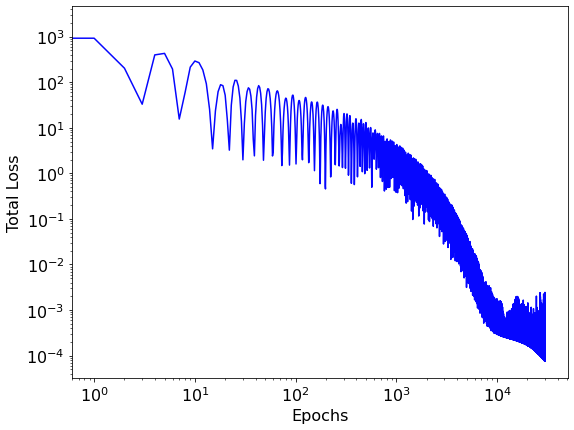

In [11]:
# Loss function
print('Training time (minutes):', runTime1/60)
plt.figure(figsize = (8,6))
plt.loglog(loss_hists1[0],'-b',alpha=0.975);
#plt.axvline(x = aarg)

plt.tight_layout()
plt.ylabel('Total Loss');plt.xlabel('Epochs')
#plt.savefig(imgdir+'finite_total_loss.png', bbox_inches = 'tight')

In [12]:
# TEST THE PREDICTED SOLUTIONS
nTest = n_train; tTest = torch.linspace(t0-.1,tf+.1,nTest)
tTest = tTest.reshape(-1,1);
tTest.requires_grad=True
t_net = tTest.detach().numpy()
psi =parametricSolutions(tTest,model1.cpu(),t0,xBC1) 
psi=psi.data.numpy(); 

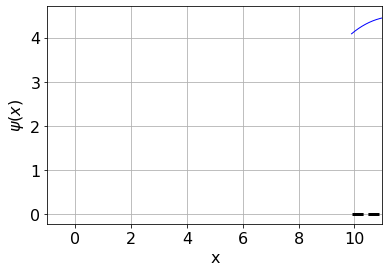

In [13]:
tru = np.sin(3*np.pi*t_net)*np.max(-1*psi)
#plt.plot(t_net, tru, '-r', linewidth = 1, label = 'True')
plt.xlim(-1,11)
plt.plot(t_net, 1*psi, '-b', linewidth=1, label = 'ANN')
plt.plot(t_net, np.zeros(len(t_net)),'--k', linewidth=3)
plt.xlabel('x')
plt.ylabel('$\psi(x)$')
plt.grid('on')

plotxs = np.linspace(-6,6,100)
L = 2
#plotys = 10*(np.heaviside(plotxs+4/8, 0) + np.heaviside(-1*plotxs+4/8, 0) + np.heaviside(plotxs-20/8, 0) + np.heaviside(-1*plotxs-20/8, 0))-10
#plt.plot(plotxs, plotys, '-r')



In [14]:
#(Loss_history, boundary_loss_history, nontriv_loss_history, SE_loss_history, Ennontriv_loss_history)
##plt.figure(figsize =(8,6))
##plt.loglog(loss_hists1[2],'-b',alpha=0.975);
#plt.axvline(x = aarg)

##plt.tight_layout()
##plt.ylabel('Non-Trivial Eigenfunction Loss');plt.xlabel('Epochs')
#plt.savefig(imgdir+'finite_nontrivfunc_loss.png', bbox_inches = 'tight')

Text(0.5, 24.3, 'Epochs')

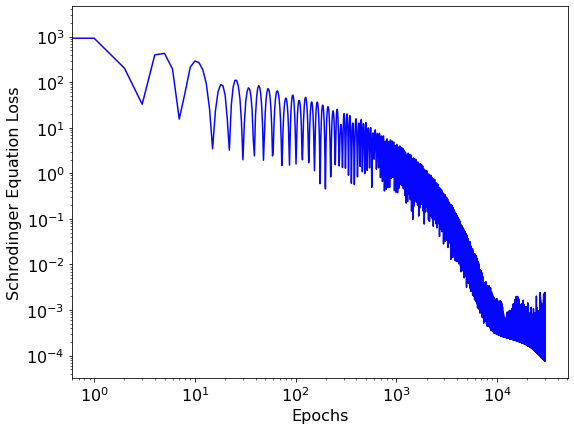

In [15]:
#(Loss_history, boundary_loss_history, nontriv_loss_history, SE_loss_history, Ennontriv_loss_history)
plt.figure(figsize =(8,6))

plt.loglog(loss_hists1[3],'-b',alpha=0.975);
#plt.axvline(x = aarg)

plt.tight_layout()
plt.ylabel('Schrodinger Equation Loss');plt.xlabel('Epochs')
#plt.savefig(imgdir+'finite_SE_loss.png', bbox_inches = 'tight')

Text(0.5, 24.3, 'Epochs')

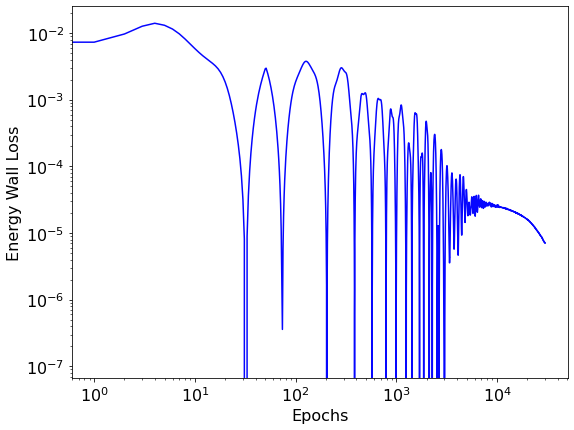

In [16]:
#(Loss_history, boundary_loss_history, nontriv_loss_history, SE_loss_history, Ennontriv_loss_history)
plt.figure(figsize =(8,6))

plt.loglog(loss_hists1[5],'-b',alpha=0.975);
#plt.axvline(x = aarg)

plt.tight_layout()
plt.ylabel('Energy Wall Loss');plt.xlabel('Epochs')
#plt.savefig(imgdir+'finite_nontrivE_loss.png', bbox_inches = 'tight')

Text(0.5, 24.3, 'Epochs')

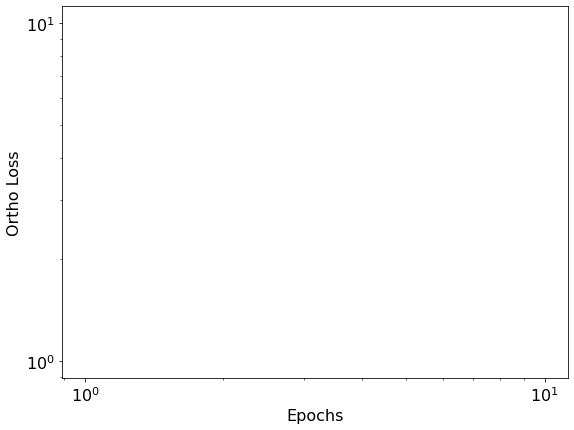

In [17]:
plt.figure(figsize =(8,6))

plt.loglog(loss_hists1[11],'-b',alpha=0.975);
#plt.axvline(x = aarg)

plt.tight_layout()
plt.ylabel('Ortho Loss');plt.xlabel('Epochs')

Text(0.5, 24.3, 'Epochs')

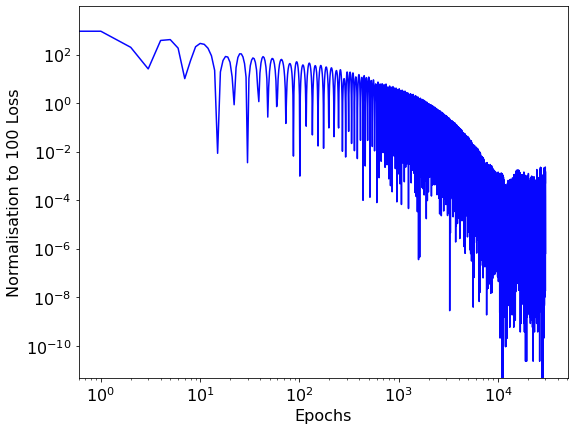

In [18]:
#(Loss_history, boundary_loss_history, nontriv_loss_history, SE_loss_history, Ennontriv_loss_history)
plt.figure(figsize =(8,6))

plt.loglog(loss_hists1[2],'-b',alpha=0.975);
#plt.axvline(x = aarg)

plt.tight_layout()
plt.ylabel('Normalisation to 100 Loss');plt.xlabel('Epochs')
#plt.savefig(imgdir+'finite_nextE_loss.png', bbox_inches = 'tight')

Text(0.5, 24.3, 'Epochs')

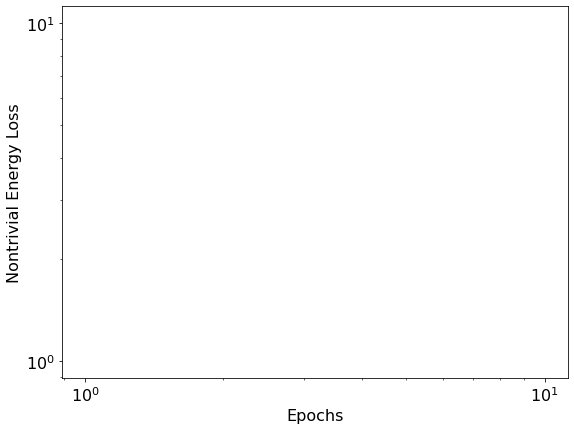

In [19]:
#(Loss_history, boundary_loss_history, nontriv_loss_history, SE_loss_history, Ennontriv_loss_history)
plt.figure(figsize =(8,6))

plt.loglog(loss_hists1[4],'-b',alpha=0.975);
#plt.axvline(x = aarg)

plt.tight_layout()
plt.ylabel('Nontrivial Energy Loss');plt.xlabel('Epochs')
#plt.savefig(imgdir+'finite_nextE_loss.png', bbox_inches = 'tight')

In [20]:
#plt.figure(figsize =(8,6))

#plt.loglog(loss_hists1[11],'-b',alpha=0.975);
#plt.axvline(x = aarg)

#plt.tight_layout()
#plt.ylabel('Probability Loss');plt.xlabel('Epochs')

Text(0.5, 0, 'Epochs')

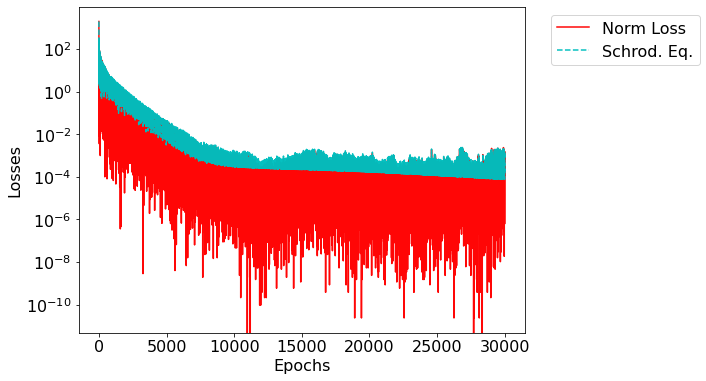

In [21]:
# Loss_history, boundary_loss_history, nontriv_loss_history, SE_loss_history, Ennontriv_loss_history, En_loss_history
plt.figure(figsize =(8,6))

#plt.loglog(loss_hists1[0],'-b',alpha=0.975, label = 'Total');
#plt.loglog(loss_hists1[1],'-g',alpha=0.975, label = 'Boundary');
#plt.semilogy([0]*(40000-24999)+loss_hists1[11],'-b',alpha=0.975, label = 'Ortho Loss');

plt.semilogy(loss_hists1[2],'-r',alpha=0.975, label = 'Norm Loss');
plt.semilogy(loss_hists1[3],'--c',alpha=0.975, label = 'Schrod. Eq.');
#plt.semilogy(loss_hists1[5],'-m',alpha=0.975, label = 'E Probe');
#plt.loglog(loss_hists1[5],'-y',alpha=0.975, label = 'Next E');
#temp22 = ([0]*(40000-24999))+loss_hists1[11]
#plt.semilogy(np.add(loss_hists1[2], np.add(loss_hists1[5],loss_hists1[3])),'-k',alpha=0.975, label = 'Total');
#plt.loglog(loss_hists1[6],'-k',alpha=0.975, label = 'Criteria');
#plt.axvline(x = aarg)
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.ylabel('Losses'); plt.xlabel('Epochs')
#plt.savefig(imgdir+'finite_all_loss.png', bbox_inches = 'tight')

Text(0.5, 28.0, 'Epochs')

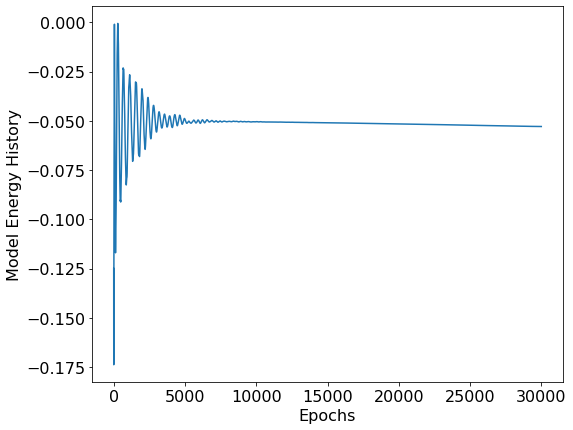

In [22]:
plt.figure(figsize = (8,6))
plt.plot(loss_hists1[8])
#plt.axvline(x = aarg)
plt.tight_layout()
plt.ylabel('Model Energy History');plt.xlabel('Epochs')
#plt.savefig(imgdir+'finite_modelE_hist.png', bbox_inches = 'tight')
#loss_hists1[8][25000]

-0.125


Text(0.5, 10.0, 'Epochs')

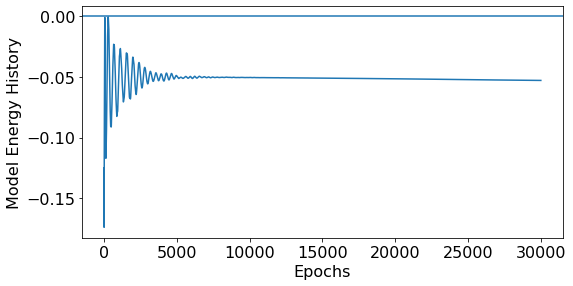

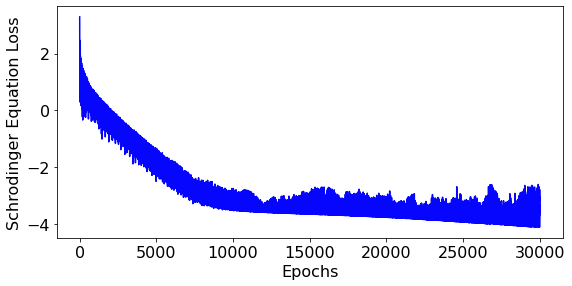

In [23]:
plt.figure(figsize = (8,4))
plt.plot(loss_hists1[8])
plt.axhline(y = 0)
plt.tight_layout()
plt.ylabel('Model Energy History');plt.xlabel('Epochs')
#plt.xlim(0,10000)
print(loss_hists1[8][0])
#plt.savefig(imgdir+'finite_modelE_hist.png', bbox_inches = 'tight')

plt.figure(figsize =(8,4))

plt.plot(np.log10(np.asarray(loss_hists1[3])),'-b',alpha=0.975);
#plt.axvline(x = aarg)

plt.tight_layout()
plt.ylabel('Schrodinger Equation Loss');plt.xlabel('Epochs')

Text(0.5, 28.0, 'Epochs')

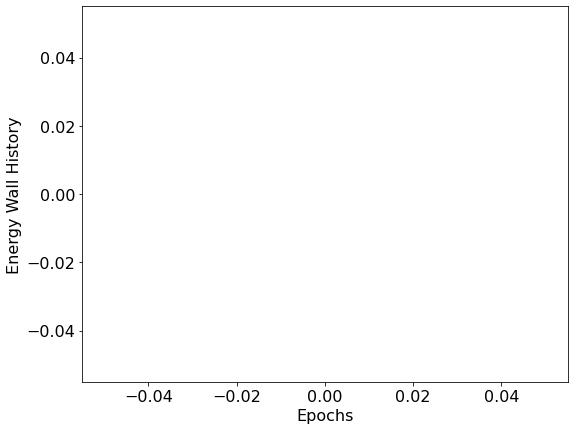

In [24]:
plt.figure(figsize = (8,6))
plt.plot(loss_hists1[9])
#plt.axvline(x = aarg)
plt.tight_layout()
plt.ylabel('Energy Wall History');plt.xlabel('Epochs')
#plt.savefig(imgdir+'finite_Ewall_hist.png', bbox_inches = 'tight')

tensor([-0.0529], grad_fn=<SelectBackward>)


Text(0.5, 0, 'x')

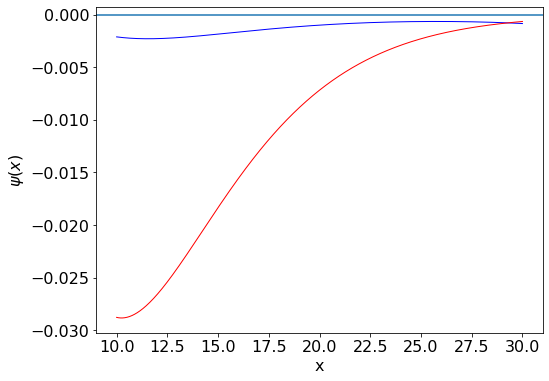

In [29]:
tTest = torch.linspace(0,60,1000).reshape((-1,1))
bin = 1
#loss_hists1[10][bin][0]
tTestnp = tTest.detach().numpy()
const_a = 1
psi_0to10 = parametricSolutions(tTest,model1.cpu(),t0,xBC1)
print(model1(tTest)[1][0])

temp_max1 = max(-1*psi_0to10.data.numpy()/10)
temp_max2 = max(1/2/np.sqrt(6)*const_a**(-3/2)*(tTestnp/const_a)*np.exp(-tTestnp/2/const_a))
temp_max3 = max(8/27/np.sqrt(6)*const_a**(-3/2)*(1-tTestnp/6/const_a)*(tTestnp/const_a)*np.exp(-tTestnp/3/const_a))
temp_max4 = max(5/16/np.sqrt(15)*const_a**(-3/2)*(1-tTestnp/4/const_a+1*tTestnp**2/const_a**2/80)*(tTestnp/const_a)*np.exp(-tTestnp/4/const_a))

plt.figure(figsize = (8,6))
plt.plot(tTestnp, -1*psi_0to10.data.numpy()/10/temp_max1*temp_max3, '-b', linewidth=1, label = 'n = 1')
#plt.plot(tTestnp, 1/2/np.sqrt(6)*const_a**(-3/2)*(tTestnp/const_a)*np.exp(-tTestnp/2/const_a), '-r', linewidth=1, label = 'n = 2, l = 1')
plt.plot(tTestnp, 8/27/np.sqrt(6)*const_a**(-3/2)*(1-tTestnp/6/const_a)*(tTestnp/const_a)*np.exp(-tTestnp/3/const_a), '-r', linewidth=1, label = 'n = 3, l = 1')
#plt.plot(tTestnp, 5/16/np.sqrt(15)*const_a**(-3/2)*(1-tTestnp/4/const_a+1*tTestnp**2/const_a**2/80)*(tTestnp/const_a)*np.exp(-tTestnp/4/const_a), '-r', linewidth=1, label = 'n = 4, l = 1')
plt.axhline(0)
#plt.plot(t_net, 1/np.sqrt(2)*const_a**(-3/2)*np.exp(-tTestnp/const_a)*(1-tTestnp/2/const_a), '-r', linewidth = 1 )
#plt.plot(t_net, 2*const_a**(-3/2)*np.exp(-tTestnp/const_a), '-r', linewidth=1, label = 'n = 1')

#plt.plot(t_net, 1*psi_10to20.data.numpy()/np.max(np.abs(psi_10to20.data.numpy())), '-g', linewidth=1, label = 'n = 2')
#plt.plot(t_net, 1*psi_20to30.data.numpy()/np.max(np.abs(psi_20to30.data.numpy())), '-r', linewidth=1, label = 'n = 3')

plt.ylabel('$\psi(x)$'); plt.xlabel('x')


[[1.1012889e-07]]


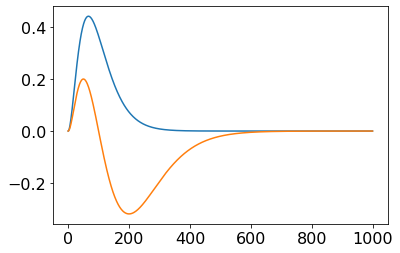

In [26]:
testorth1 = 1/2/np.sqrt(6)*const_a**(-3/2)*(tTestnp/const_a)*np.exp(-tTestnp/2/const_a)*tTestnp
testorth2 = 8/27/np.sqrt(6)*const_a**(-3/2)*(1-tTestnp/6/const_a)*(tTestnp/const_a)*np.exp(-tTestnp/3/const_a)*tTestnp

print(np.dot(np.reshape(testorth1, (1,-1)), np.reshape(testorth2, (-1,1))))

plt.plot(testorth1)
plt.plot(testorth2)

tensor([-0.0529], grad_fn=<SelectBackward>)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


ValueError: ignored

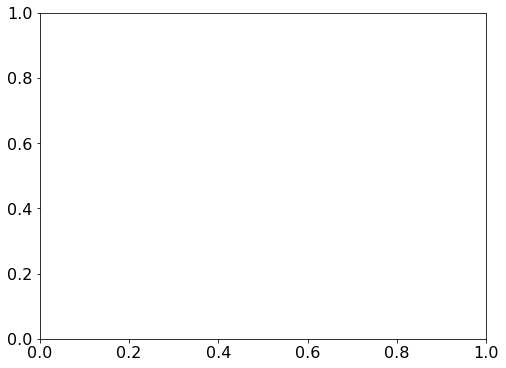

In [27]:
binval = 13
bin = 1
psi_0to10 = parametricSolutions(tTest,loss_hists1[10][bin][0].cpu(),t0,xBC1)
print(loss_hists1[10][bin][0](tTest)[1][0])

tTestnp = tTest.detach().numpy()
const_a = 9e-2

plt.figure(figsize = (8,6))
plt.plot(t_net, 1*psi_0to10.data.numpy()/tTestnp/np.max(np.abs(psi_0to10.data.numpy())), '-b', linewidth=1, label = 'n = 1')
#plt.plot(t_net, 1/np.sqrt(2)*const_a**(-3/2)*np.exp(-tTestnp/const_a)*(1-tTestnp/2/const_a), '-r', linewidth = 1 )

plotxs = np.linspace(-6,6,100)

plt.ylabel('$\psi(x)$'); plt.xlabel('x')


In [ ]:
loss_hists1[8][-2]

In [ ]:
psi_dirac_x = loss_hists1[10][bin][2][0]
psi_dirac_H = loss_hists1[10][bin][2][2]
psi_dirac = loss_hists1[10][bin][2][3]
#psiHpsi_over_psipsi = np.trapz()
#psi_dirac_x



In [ ]:
sorted_index = torch.argsort(psi_dirac_x, dim = 0)
sorted_x = psi_dirac_x[sorted_index][:,0,0]
sorted_psi = psi_dirac[sorted_index][:,0,0]
sorted_H = psi_dirac_H[sorted_index][:,0,0]
#psi_psi = np.trapz(sorted_psi**2, sorted_x)
#sort_norm_psi = sorted_psi/(psi_psi**(1/2))
pHp_pp = np.trapz(np.multiply(sorted_H.cpu().data.numpy(),sorted_psi.cpu().data.numpy()), sorted_x.cpu().data.numpy())/np.trapz(sorted_psi.cpu().data.numpy()**2, sorted_x.cpu().data.numpy())
pHp_pp


In [ ]:
#parametricSolutions2(tTest.cuda(), t0, xBC1).cpu().detach().numpy().shape
#psi_0to10.detach().numpy()
np.dot(parametricSolutions2(tTest.cuda(), t0, xBC1).cpu().detach().numpy().reshape(1,-1), psi_0to10.detach().numpy())

# Numerical Solutions

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as scl
import scipy.optimize as opt
# Setup the input values
hbar=1
m=1

for a in [1.,2.]:
    z0 = 4*np.pi /2
    V0 = 10 # (z0*hbar/a)**2 /m/2
    z0 = a/hbar * np.sqrt(2*m*V0)
    # V0 = 2*(np.pi*hbar/a)**2 /m/8 

    epsilon = 0.0001 # Sufficiently small but not zero to avoid devide by zero issues.
    # Setup the two equations that need to be solved. 
    def opt_fun1(z,z0):
        return( np.tan(z) - np.sqrt((z0/z)**2 -1 ))
    def opt_fun2(z,z0):
        return( -1/np.tan(z) - np.sqrt((z0/z)**2 -1 ))

    result = []
    z = []
    Ex = []
    for i in range(2*int(z0/np.pi)+1):
        if i*np.pi/2 < z0:
            if (i%2 == 0):
                result.append(opt.root_scalar(opt_fun1,z0,bracket=[np.pi*i/2+epsilon,min((i+1)*np.pi/2-epsilon,z0)]))
            else:
                result.append(opt.root_scalar(opt_fun2,z0,bracket=[np.pi*i/2+epsilon,min((i+1)*np.pi/2-epsilon,z0)]))
            if not result[i].converged: 
                print(result[i])
                z.append(0)
                Ex.append(0)
            else:
                z.append(result[i].root)
                Ex.append((z[i]*hbar/a)**2 /m/2 - V0)
        else:
            z.append(0)
            Ex.append(0)
    print("Potential strenght = {:7.3f}".format(V0))
    print("Widht of the well  = {:7.37}".format(a))
    print("\n Binding energies are predicted to be:")
    for i in range(len(Ex)):
        if Ex[i]<0:print(" Ex[{:1d}] = {:6.3f}".format(i,Ex[i]))
    print()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as scl
hbar=1
m=1
N = 2048
x_max = 8
x_min = -x_max

a=1.
b_vals= np.linspace(0,10,11)*a/5 # 1*a
E_store=[]
Psi_store=[]

##############
b = 0.8
if a+b > x_max/2:
    print("Warning, the a+b is getting too close to the edge!")
x = np.linspace(x_min,x_max,N)
# We want to store step size, this is the reliable way:
h = x[1]-x[0] # Should be equal to 2*np.pi/(N-1)

# V0 = 2*(np.pi*hbar/a)**2 /m/8 


#
#
V=np.zeros(N)
for i in range(N):
    #if x[i] > -a -b/2. and x[i]< -b/2.:
    #    V[i]= -V0
    #elif x[i] > b/2. and x[i] < b/2. + a :
    #    V[i]= -V0
    if x[i] > -1.7 and x[i] < -0.7:
      V[i] = -V0
    elif x[i] > -0.5 and x[i] < 0.5:
      V[i] = -V0
    elif x[i] > 0.7 and x[i] < 1.7:
      V[i] = -V0

Mdd = 1./(h*h)*(np.diag(np.ones(N-1),-1) -2* np.diag(np.ones(N),0) + np.diag(np.ones(N-1),1))
H = -(hbar*hbar)/(2.0*m)*Mdd + np.diag(V) 
E,psi = np.linalg.eigh(H) # This computes the eigen values and eigenvectors
E_store.append(E)
Psi_store.append(psi)

#print("Binding Energy levels for b = {:5.3f} a: ".format(b/a))
for i in range(len(E)):
    if E[i]<0:
        #if np.allclose(b,0): 
        #    print("E[{}] = {:7.4f}   Ex[{}] = {:7.4f}".format(i,E[i],i,Ex[i]))
        #else:
            print("E[{}] = {:7.4f} ".format(i,E[i]))
            
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(111)
ax1.set_xlabel("x")
ax1.set_ylabel("$\psi_n(x)$")
for i in range(2):
#    if E[i]<0:                 # Only plot the bound states. The scattering states are not reliably computed.
        if psi[:,i][N//2+10] < 0:   # Flip the wavefunctions if it is negative at large x, so plots are more consistent.
            ax1.plot(x,-psi[:,i]/np.sqrt(h),label="$E_{}$={:>8.3f}".format(i,E[i]))
        else:
            ax1.plot(x,psi[:,i]/np.sqrt(h),label="$E_{}$={:>8.3f}".format(i,E[i]))

            #plt.title("Solutions to double finite well, b = {:4.2f} a".format(b/a))

# Plot the potential as well, on a separate y axis
ax2 = ax1.twinx()
ax2.set_ylabel("Energy")                            # To get separate energy scale
ax2.plot(x,V,color="Gray",label="V(x)")
ax1.set_xlim((-7,7))
legendh1,labels1 = ax1.get_legend_handles_labels()  # For putting all legends in one box.
legendh2,labels2 = ax2.get_legend_handles_labels()
plt.legend(legendh1+legendh2,labels1+labels2,loc="lower right")
#plt.savefig("Double_Finite_Square_Well_WaveFunctions_b_{}.pdf".format(10*int(b/a)))
plt.show()

In [ ]:
E_store

In [ ]:
E[:10]

In [ ]:
nTest = n_train; tTest = torch.linspace(t0-.1,tf+.1,nTest)
tTest = tTest.reshape(-1,1);
tTest.requires_grad=True
t_net = tTest.detach().numpy()
psi1 =parametricSolutions(tTest,model1,t0,xBC1) 
psi1=psi1.data.numpy(); 

In [ ]:
t_net

In [ ]:
psi

In [ ]:
psi1

In [ ]:
x_nn = np.linspace(-6,6, )

In [ ]:
x[256:-256]

In [ ]:
tTest1 = torch.from_numpy(x[256:-256]).float()
tTest1 = tTest1.reshape(-1,1);
tTest1.requires_grad=True
t_net1 = tTest1.detach().numpy()
psi1 =parametricSolutions(tTest1,model1,t0,xBC1) 
psi1=psi1.data.numpy(); 

In [ ]:
plt.plot(x[256:-256], psi1)

psi1

In [ ]:
plt.plot(x[256:-256], psi[:,0][256:-256])
plt.plot(x[256:-256], 1*psi1*np.max(psi[:,0][256:-256])/np.max(1*psi1))
print('MSE in eigenfunction:')
print(np.mean((psi[:,0][256:-256] - 1*psi1*np.max(psi[:,0][256:-256])/np.max(1*psi1))**2))

print('Squared Error in Eigenvalue:')
print((loss_hists1[10][1][0](tTest.float().cuda())[1][0].cpu().data.numpy()[0]-10-E[0])**2)